<a href="https://colab.research.google.com/github/aswinaus/Reinforcement-Learning/blob/main/Intrinsic_Dimention_Estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training with subspace dimension: 100
Test accuracy: 0.0980
Training with subspace dimension: 500
Test accuracy: 0.0980
Training with subspace dimension: 1000
Test accuracy: 0.0980
Training with subspace dimension: 2000
Test accuracy: 0.0980
Training with subspace dimension: 3000
Test accuracy: 0.0980
Training with subspace dimension: 5000
Test accuracy: 0.0980
Training with subspace dimension: 10000
Test accuracy: 0.0980


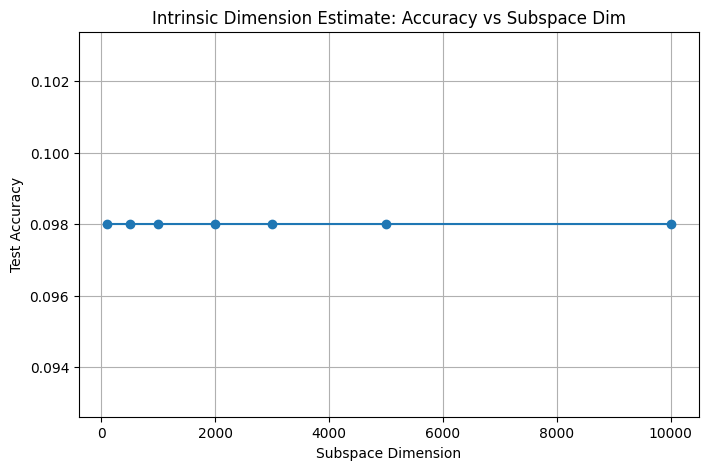

In [11]:
# 📦 Setup
!pip install torch torchvision --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 📚 Basic MLP for MNIST
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# 🎯 Project gradients into a low-dimensional random subspace
class SubspaceOptimizer(optim.SGD):
    def __init__(self, params, lr, subspace_dim):
        super().__init__(params, lr=lr)
        self.subspace_dim = subspace_dim
        self.proj_matrices = {} # Use a dictionary to store proj matrices per param size

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    grad_flat = p.grad.view(-1)
                    full_dim = grad_flat.size(0)

                    # Initialize proj matrix for this parameter size if not exists
                    if full_dim not in self.proj_matrices:
                        self.proj_matrices[full_dim] = torch.randn(full_dim, self.subspace_dim).to(p.grad.device)

                    proj_matrix = self.proj_matrices[full_dim]

                    low_d = torch.matmul(grad_flat.unsqueeze(0), proj_matrix)
                    proj_grad = torch.matmul(low_d, proj_matrix.T).squeeze(0)
                    p.grad.data.copy_(proj_grad.view_as(p)) # Use .data.copy_ for assignment
        super().step(closure)

# 📊 Training and evaluation
def train_model(subspace_dim, epochs=3):
    model = SimpleNet().to(device)
    model.train()

    optimizer = SubspaceOptimizer(model.parameters(), lr=0.01, subspace_dim=subspace_dim)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

    # Quick evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# 🔧 Data and setup
transform = transforms.ToTensor()
train_loader = DataLoader(datasets.MNIST(root='.', train=True, download=True, transform=transform), batch_size=128, shuffle=True)
test_loader = DataLoader(datasets.MNIST(root='.', train=False, transform=transform), batch_size=128)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 🚀 Run across subspace sizes
subspace_dims = [100, 500, 1000, 2000, 3000, 5000, 10000]
accuracies = []

for dim in subspace_dims:
    print(f"Training with subspace dimension: {dim}")
    acc = train_model(subspace_dim=dim)
    print(f"Test accuracy: {acc:.4f}")
    accuracies.append(acc)

# 📈 Plot
plt.figure(figsize=(8,5))
plt.plot(subspace_dims, accuracies, marker='o')
plt.title("Intrinsic Dimension Estimate: Accuracy vs Subspace Dim")
plt.xlabel("Subspace Dimension")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()